### Requirements: _requirements.txt_

In [3]:
from bs4 import BeautifulSoup
import requests
import calendar
from tqdm import tqdm
import pandas as pd
import nltk
import numpy as np
from tqdm.notebook import tqdm
from wordcloud import WordCloud, ImageColorGenerator
from collections import Counter
import matplotlib.pyplot as plt
import huspacy
import spacy
import pickle
from nltk.corpus import stopwords

In [4]:
nlp = huspacy.load()

* * *
### Acquiring the Origo headlines

#### Iterating through the addresses to get all available data 

In [3]:
base_url = 'https://www.origo.hu/hir-archivum/'
cal = calendar.Calendar()

In [4]:
datelist = []
for year in range(1998, 2023):
    for month in range(1, 13):
        monthdays = [day for day in cal.itermonthdays(year, month) if day != 0]
        for day in monthdays:
            if month < 10 and day < 10:
                datelist.append(str(year) + '/' + str(year) + '0' + str(month) + '0' + str(day))
            if month >= 10 and day < 10:
                datelist.append(str(year) + '/' + str(year) + str(month) + '0' + str(day))
            if month < 10 and day >= 10:
                datelist.append(str(year) + '/' + str(year) + '0' + str(month) + str(day))
            if month >= 10 and day >= 10:
                datelist.append(str(year) + '/' + str(year) + str(month) + str(day))

In [5]:
len(datelist)

9131

 #### Creating a list out of the links where the data will be acquired from

In [6]:
origo_urls = []
for date in datelist:
    origo_urls.append(base_url + date + '.html')

#### Extracting the headlines using the previously defined list
On the origo archive website the news headlines are defined as h3 type headings, they will be extracted using requests and with beautifulsoup, the text can be obtained omitting the HTML code

In [7]:
headlines = []
for url in tqdm(origo_urls):
    response = requests.get(str(url))
    soup = BeautifulSoup(response.text, 'html.parser')
    news_titles = soup.findAll('h3')
    for title in news_titles:
        headlines.append(title.text)

  0%|          | 0/9131 [00:00<?, ?it/s]

In [8]:
len(headlines)

757657

* * *
### Conversion into dataframe and exporting the result as a csv file
_using pandas_

In [9]:
headline_df = pd.DataFrame(headlines, columns = ['headline'])
headline_df.to_csv('headlines.csv', encoding = 'utf-8')

Loading the csv as a pandas data frame

In [10]:
headline_df = pd.read_csv('headlines.csv')
del headline_df['Unnamed: 0']

In [12]:
doc_headlines = nlp.pipe(headline_df['headline'].values, n_process =5, batch_size = 2000)

In [13]:
headlines_processed = [headline for headline in tqdm(doc_headlines, total = headline_df['headline'].shape[0])]

  0%|          | 0/757657 [00:00<?, ?it/s]

### Adding processed column

In [24]:
headline_df['processed'] = [headline for headline in headlines_processed]

In [42]:
headline_df['lemma'] = [[token.lemma_ for token in headline] for headline in headline_df['processed']]

### Saving/loading

In [ ]:
headline_df.to_pickle("headline_df")

In [8]:
headline_df = pd.read_pickle("headline_df_with_categories")

* * *
### Gathering words attributed to women and men
- Hungarian first names
- English first names
- feminine/masculine family- or profession-related expressions

Sources: <br>
_hu: http://benoke98.f.fazekas.hu/alapadatok/ <br>
en: https://github.com/organisciak/names/raw/master/data/us-living-estimate-names-by-sex-state-year.csv_

In [9]:
hunames = pd.read_csv('anyakonyvezheto_utonevek_2019_08.csv', delimiter=';')
male_words = hunames[hunames.nem == 1].nev.tolist()
female_words = hunames[hunames.nem == 2].nev.tolist()

In [10]:
ennames = pd.read_csv('us-living-estimate-names-by-sex-state-year.csv')
ennames = ennames[ennames.year == 2013]
male_en = ennames[ennames.sex == 'M'].name.tolist()
for name in male_en:
    male_words.append(name)

In [11]:
female_en = ennames[ennames.sex == 'F'].name.tolist()
for name in female_en:
    female_words.append(name)

_Removing confusing names and duplicates_

In [12]:
female_words = list(set(female_words))

In [13]:
removelist_f = ['London', 'Európa' 'Berlin', 'Paris', 'Színes', 'Mercedes', 'Remény', 'Áfonya', 'Ajándék', 'Ember', 'Csillag', 'Fortuna', 'India']
female_words = [word for word in female_words if word not in removelist_f]

#### Extending the list by some additional words

In [14]:
female_words.extend(['barátnő', 'nő', 'ápolónő', 'feleség', 'húg', 'nővér', 'lány', 'anya', 'bombázó', 'szépség',
                    'színésznő', 'csaj', 'nővér', 'anya', 'kislány', 'hercegné', 'hercegnő', 'királynő', 
                     'turistalány', 'védőnő', 'tanárnő', 'háziasszony'])

male_words.extend(['fiú', 'férfi', 'férj', 'báty', 'öcs', 'apa', 'kisfiú', 'király', 'herceg', 'sógor',
                  'nagyapa', 'unokaöcs'])

* * *
### Female and male-related headlines

In [15]:
female = []
for index, row in tqdm(headline_df.iterrows(), total = len(headline_df)):
    isfemale = False
    for word in row['lemma']:
        if word in female_words:
            isfemale = True
    if isfemale:
        female.append(1)
    else:
        female.append(0)

headline_df['female'] = [value for value in female]

  0%|          | 0/757657 [00:00<?, ?it/s]

In [17]:
male = []
for index, row in tqdm(headline_df.iterrows(), total = len(headline_df)):
    ismale = False
    for word in row['lemma']:
        if word in male_words:
            ismale = True
    if ismale:
        male.append(1)
    else:
        male.append(0)

headline_df['male'] = [value for value in male]

  0%|          | 0/757657 [00:00<?, ?it/s]

### Create category column
- male: only male
- female: only female
- mixed: both female and male
- none: neither female nor male

In [18]:
def categorise(row):  
    if row['female'] == 0 and row['male'] == 0:
        return 'neutral'
    elif row['female'] == 1 and row['male'] == 0:
        return 'female'
    elif row['female'] == 0 and row['male'] == 1:
        return 'male'
    else:
        return 'mixed'

In [19]:
headline_df['category'] = headline_df.apply(lambda row: categorise(row), axis=1)

_Save_

In [20]:
headline_df.to_pickle("headline_df_with_categories")

In [135]:
descriptive_stats = pd.DataFrame(headline_df[["category"]].value_counts())
descriptive_stats

,0
category,
neutral,619974
male,85381
female,38974
mixed,13328


* * *

## Scattertext diagram <br>
https://colab.research.google.com/drive/1snxAP8X6EIDi42FugJ_h5U-fBGDCqtyS#scrollTo=T0fWj2J66Xu3

In [176]:
import scattertext as st

In [179]:
sample_df = headline_df.sample(n = 20000, random_state = 42)
sample_df[(sample_df.category != 'neutral') & (sample_df.category != 'mixed')]

SyntaxError: invalid syntax (<ipython-input-179-5660ae3d3f28>, line 3)

In [111]:
corpus = (st.CorpusFromPandas(sample_df, 
                              category_col='category', 
                              text_col='headline',
                              nlp = st.whitespace_nlp_with_sentences)
          .build())

Remove unused categories (mixed and none), only use either male- or female related headlines

Visualizing term associations <br>
_The output is an interactive html scatterplot depicting the association between the frequency of words and the categories they belong to_

In [112]:
html = st.produce_scattertext_explorer(
    corpus,
    category='female', 
    not_category_name='male',
    metadata = sample_df['category']
)

open("Gender-association-Visualization.html", 'wb').write(html.encode('utf-8')) 

2790447

_Kessler (2017)_ <br>
Source: https://github.com/JasonKessler/scattertext

* * *
### Context (without the identifying words) to create WordCloud

In [123]:
female_lem_context = []
for headline in tqdm(female_headlines_lem):
    for word in headline:
        if word not in (female_words):
            female_lem_context.append(word)

  0%|          | 0/51573 [00:00<?, ?it/s]

In [56]:
male_lem_context = []
for headline in tqdm(male_headlines_lem):
    for word in headline:
        if word not in (male_words):
            male_lem_context.append(word)

  0%|          | 0/109782 [00:00<?, ?it/s]

In [127]:
female_lem_context_1 = []
swords_addition = [',', '?', '.', ':', '(', ')', '!', '-', 'is', 'ha', 'akár', 'miatt']
[swords.append(symbol) for symbol in swords_addition]
for word in tqdm(female_lem_context):
    if word not in swords:
        female_lem_context_1.append(word)

female_pickle = pickle.dumps(female_lem_context_1)
# female_lem_context_1 = pickle.loads(female_pickle)

NameError: name 'swords' is not defined

In [ ]:
male_lem_context_1 = []
swords_addition = [',', '?', '.', ':', '(', ')', '!', '-', 'is', 'ha', 'akár', 'miatt']
[swords.append(symbol) for symbol in swords_addition]
for word in tqdm(male_lem_context):
    if word not in swords:
        male_lem_context_1.append(word)

male_pickle = pickle.dumps(male_lem_context_1)
# male_lem_context_1 = pickle.loads(male_pickle)

### Female context

In [273]:
doc_fem_pipe = nlp.pipe(female_lem_context_1, n_process=5, batch_size=2000)
doc_fem = [doc for doc in tqdm(doc_fem_pipe, total=len(female_lem_context_1))]

  0%|          | 0/237179 [00:00<?, ?it/s]

### Male context

In [277]:
doc_male_pipe = nlp.pipe(male_lem_context_1, n_process=5, batch_size=2000)
doc_male = [doc for doc in tqdm(doc_male_pipe, total=len(male_lem_context_1))]

  0%|          | 0/500607 [00:00<?, ?it/s]

In [281]:
femdict = Counter(doc_fem)
maledict = Counter(doc_male)

* * *
### Most common words that occur in woman-related headlines

In [306]:
fem_adj = []
for n in tqdm(range(len(doc_fem))):
    if doc_fem[n][0].tag_ == 'ADJ':
        fem_adj.append(doc_fem[n][0].lemma_)

fem_adj = Counter(fem_adj).most_common()

  0%|          | 0/237179 [00:00<?, ?it/s]

In [319]:
fem_noun = []
for n in tqdm(range(len(doc_fem))):
    if doc_fem[n][0].tag_ == 'NOUN':
        fem_noun.append(doc_fem[n][0].lemma_)

fem_noun = Counter(fem_noun).most_common()

  0%|          | 0/237179 [00:00<?, ?it/s]

#### Graph of top 15 adjectives in female-related headlines

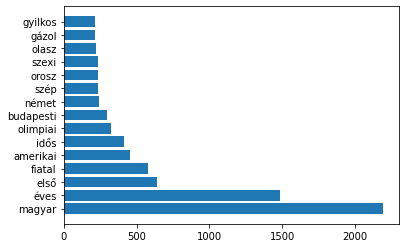

In [347]:
adjectives_f = [element[0] for element in fem_adj[0:15]]
freq_adj_f = [element[1] for element in fem_adj[0:15]]

plt.barh(np.arange(len(adjectives_f)), freq_adj_f)
plt.yticks(np.arange(len(adjectives_f)), adjectives_f)
plt.savefig('female_adj.png')

#### Graph of top 15 nouns in female-related headlines

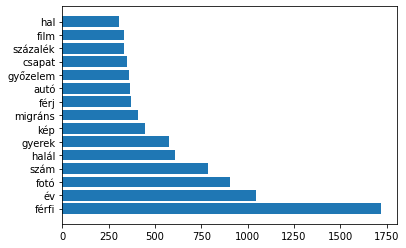

In [346]:
nouns_f = [element[0] for element in fem_noun[0:15]]
freq_noun_f = [element[1] for element in fem_noun[0:15]]

plt.barh(np.arange(len(nouns_f)), freq_noun_f)
plt.yticks(np.arange(len(nouns_f)), nouns_f)
plt.savefig('female_noun.png')

* * *
 ### Most common words that occur in male-related headlines

In [327]:
m_adj = []
for n in tqdm(range(len(doc_male))):
    if doc_male[n][0].tag_ == 'ADJ':
        m_adj.append(doc_male[n][0].lemma_)

m_adj = Counter(m_adj).most_common()

  0%|          | 0/500607 [00:00<?, ?it/s]

In [329]:
m_noun = []
for n in tqdm(range(len(doc_male))):
    if doc_male[n][0].tag_ == 'NOUN':
        m_noun.append(doc_male[n][0].lemma_)

m_noun = Counter(m_noun).most_common()

  0%|          | 0/500607 [00:00<?, ?it/s]

#### Graph of top 20 adjectives (male)

In [ ]:
adjectives_m = [element[0] for element in m_adj[0:20]]
freq_adj_m = [element[1] for element in m_adj[0:20]]

plt.barh(np.arange(len(adjectives_m)), freq_adj_m)
plt.yticks(np.arange(len(adjectives_m)), adjectives_m)
plt.savefig('male_adj.png')

#### Graph of top 20 nouns (male)

In [ ]:
nouns_m = [element[0] for element in m_noun[0:15]]
freq_noun_m = [element[1] for element in m_noun[0:15]]

plt.barh(np.arange(len(nouns_m)), freq_noun_m)
plt.yticks(np.arange(len(nouns_m)), nouns_m)
plt.savefig('male_noun.png')

* * *
### WordCloud of female headlines

In [341]:
wordcloud_fem=Counter([doc[0].lemma_ for doc in tqdm(doc_fem)])

  0%|          | 0/237179 [00:00<?, ?it/s]

(-0.5, 1999.5, 999.5, -0.5)

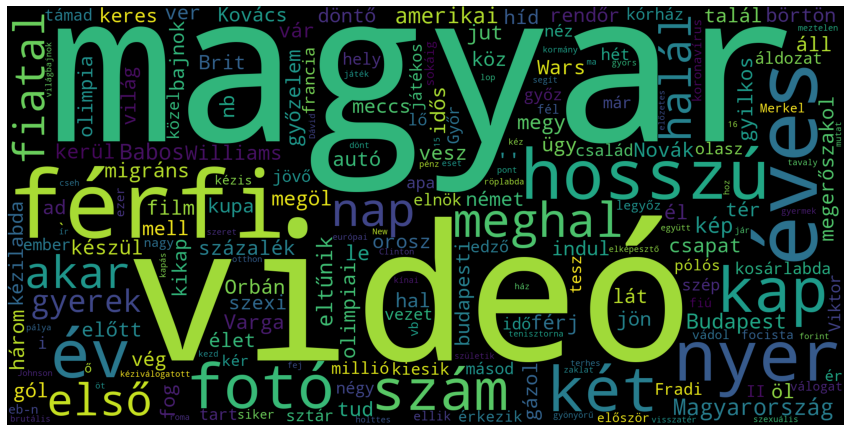

In [342]:
wordcloud=WordCloud(width = 2000, height = 1000).generate_from_frequencies(wordcloud_fem)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig('fem_wordcloud.png')

* * *
### WordCloud of male headlines

In [344]:
wordcloud_m=Counter([doc[0].lemma_ for doc in tqdm(doc_male)])

  0%|          | 0/500607 [00:00<?, ?it/s]

(-0.5, 1999.5, 999.5, -0.5)

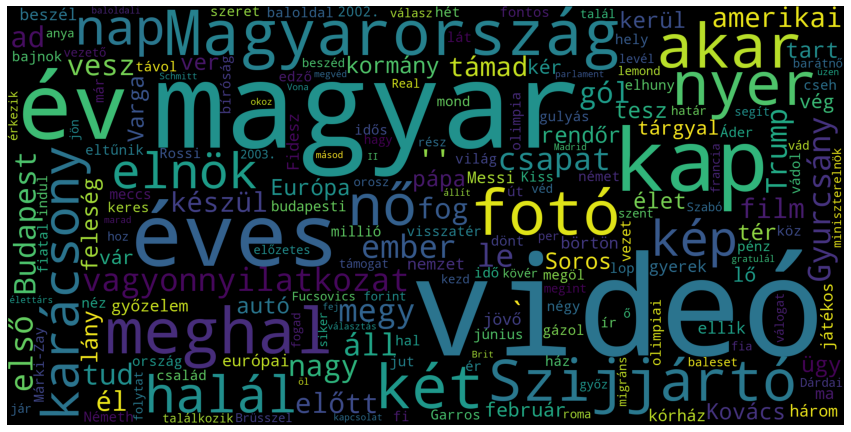

In [345]:
wordcloud=WordCloud(width = 2000, height = 1000).generate_from_frequencies(wordcloud_m)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig('male_wordcloud.png')

* * * 
## Most common words without stopwords

In [194]:
most_common = headline_df["lemma"].explode().value_counts().to_frame()
swords_addition = [',', '?', '.', ':', '(', ')', '!', '-', 'is', 'ha', 'akár', 'miatt']
[swords.append(symbol) for symbol in swords_addition]

[None, None, None, None, None, None, None, None, None, None, None, None]

In [195]:
for index, row in most_common.iterrows():
    if index in swords:
        most_common.drop(index, inplace = True )

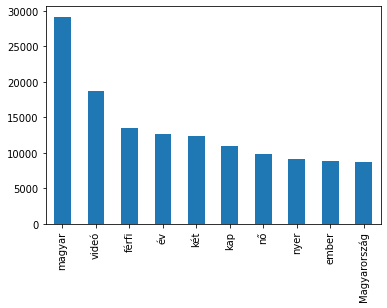

In [202]:
fig, ax = plt.subplots()
most_common['lemma'][0:10].plot(ax=ax, kind='bar')
plt.savefig('mostcommon.png')

 ### Textnets

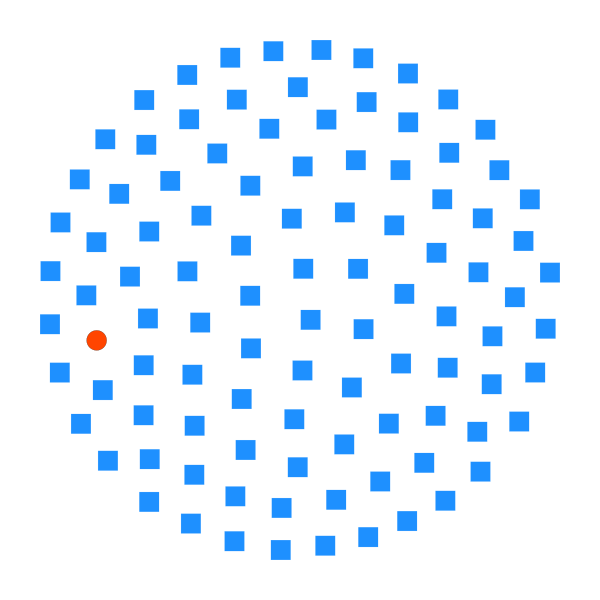

In [13]:
import textnets as tn
corpus = tn.Corpus(headline_df['headline'][0:100], lang="hu")
t = tn.Textnet(corpus.tokenized(), min_docs=1)
t.plot(label_nodes=True,
       show_clusters=True)